In [1]:
import numpy as np
import re, json, csv
import torch
from matplotlib import pyplot as plt
from pymongo import MongoClient
from tqdm.notebook import tqdm
from pprint import PrettyPrinter
from typing import Union, Iterable
from bson.objectid import ObjectId
from torchmetrics.text.bert import BERTScore
from torchmetrics.text.rouge import ROUGEScore
from torchmetrics.text.bleu import BLEUScore
from transformers import AutoModelForSeq2SeqLM, AutoModelForCausalLM, AutoConfig, AutoTokenizer
from torchmetrics.functional import pairwise_cosine_similarity
from torchmetrics.functional.text.bert import _get_precision_recall_f1
from functools import partial
from collections import Counter, defaultdict
from itertools import chain
from math import log
from multiprocessing import Pool
from typing import List
from pymongo import MongoClient
from typing import Set

pprint = PrettyPrinter().pprint

In [2]:
DEVICE = "cpu"

In [3]:
db = MongoClient("mongodb://localhost:27017")["cuda_snippets"]
train_db = db["train"]
validation_db = db["validation"]

### Get model

### Calculate ROUGE

In [4]:
def compute_rouge_score(target_sentences : Iterable[str], pred_senteces : Iterable[str], tokenizer):
    tokenizer_fn = lambda x: tokenizer.convert_ids_to_tokens(tokenizer.encode(x))
    rouge_metric = ROUGEScore(tokenizer=tokenizer_fn)
    # rouge_metric.update(pred_senteces, target_sentences)
    return rouge_metric(pred_senteces, target_sentences)

### Calculate BLEU

In [5]:
def compute_bleu_score(target_sentences : Iterable[str], pred_senteces : Iterable[str], tokenizer):
    bleu_metric = BLEUScore(tokenizer=tokenizer)
    bleu_metric.update(pred_senteces, [[s] for s in target_sentences])
    return bleu_metric.compute()

### Calculate BERT score

In [6]:
def update(self, preds: List[str], targets: List[str]) -> None:
        """Store predictions/references for computing BERT scores.

        It is necessary to store sentences in a tokenized form to ensure the DDP mode working.
        """
        
        preds_tokenized_data = self.tokenizer(preds, max_length=1024, truncation=True, return_tensors="pt", padding=True)
        preds_dict = {"input_ids": preds_tokenized_data["input_ids"], "attention_mask": preds_tokenized_data["attention_mask"]}
        target_tokenized_data = self.tokenizer(targets, max_length=1024, truncation=True, return_tensors="pt", padding=True)
        target_dict = {"input_ids": target_tokenized_data["input_ids"], "attention_mask": target_tokenized_data["attention_mask"]}

        self.preds_input_ids.append(preds_dict["input_ids"])
        self.preds_attention_mask.append(preds_dict["attention_mask"])
        self.target_input_ids.append(target_dict["input_ids"])
        self.target_attention_mask.append(target_dict["attention_mask"])
        
def compute_bert_score2(target_sentences : Iterable[str], pred_senteces : Iterable[str], tokenizer, model : torch.nn.Module, *args, **kwargs):
    BERTScore.update = update
    user_forward_fn = lambda model, d: model.get_input_embeddings()(d["input_ids"])
    bert_metric = BERTScore(model=model, user_tokenizer=tokenizer, user_forward_fn=user_forward_fn, device=DEVICE, verbose=True, num_layers=0, max_length=600)
    # bert_metric.update = update
    output = {}
    for key, vals in bert_metric(preds=pred_senteces, targets=target_sentences).items():
        output[key] = float(np.mean(vals))
    
    return output
#     bert_metric.update(bert_metric, pred_senteces, target_sentences)
#     return bert_metric.compute()

In [7]:
def get_kernel_prefixes(kernel : str) -> Set[str]:
    prefixes = set()
    one_line_kernel = kernel.replace("\n", " ")
    cuda_header_prefix_re = re.compile("__(host|global|device)__")
    
    prefixes.update(cuda_header_prefix_re.findall(one_line_kernel))
    return prefixes
        

In [8]:
def compute_metrics(sources : List[str], targets : List[str], preds : List[str], tokenizer, model : torch.nn.Module, used_ratio : float = 1.0):
    assert used_ratio > 0 and used_ratio <= 1
    assert len(targets) == len(preds)
    
    samples = list(zip(targets, preds))
    np.random.shuffle(samples)
    n = round(len(samples) * used_ratio)
    
    print(f"Using random {n} samples")
        
    metrics_d = {
        "device" : {},
        "host" : {},
        "global" : {}
    }
    
    device_sentences = []
    host_sentences = []
    global_sentences = []
    
    pb = tqdm(zip(sources, targets, preds))
    i = 0
    for src, target, pred in pb:
        found = False
        
        if found := (src.find("__device__") != -1):
            device_sentences.append((target, pred))
        if found := (src.find("__host__") != -1):
            host_sentences.append((target, pred))
        if found := (src.find("__global__") != -1):
            global_sentences.append((target, pred))
        
        if not found:
            continue
        
        i += 1
        pb.set_description_str(f"{i}")
        if i >= n:
            break
    
    if len(device_sentences) == 0:
        print("WARNING: no device sample")
        # metrics_d["__device__"] = {"rouge" : 0, "bleu" : 0, "bert" : 0}
    else:
        device_targets, device_preds = zip(*device_sentences)
        metrics_d["device"] = {
            "rouge" : compute_rouge_score(device_targets, device_preds, tokenizer),
            "bleu" : compute_bleu_score(device_targets, device_preds, tokenizer),
            "bert" : compute_bert_score2(device_targets, device_preds, tokenizer, model)
        }
        print(f"__device__ ({len(device_sentences)})")
        pprint(metrics_d["device"])
        
    if len(host_sentences) == 0:
        print("WARNING: no host samples")
        # metrics_d["__host__"] = {"rouge" : 0, "bleu" : 0, "bert" : 0}
    else:
        host_targets, host_preds = zip(*host_sentences)
        metrics_d["host"] = {
            "rouge" : compute_rouge_score(host_targets, host_preds, tokenizer),
            "bleu" : compute_bleu_score(host_targets, host_preds, tokenizer),
            "bert" : compute_bert_score2(host_targets, host_preds, tokenizer, model)
        }
        print(f"__host__ ({len(host_sentences)})")
        pprint(metrics_d["host"])
        
    if len(global_sentences) == 0:
        print("WARNING: no global samples")
        # metrics_d["__global__"] = {"rouge" : 0, "bleu" : 0, "bert" : 0}
    else:
        global_targets, global_preds = zip(*global_sentences)
        metrics_d["global"] = {
            "rouge" : compute_rouge_score(global_targets, global_preds, tokenizer),
            "bleu" : compute_bleu_score(global_targets, global_preds, tokenizer),
            "bert" : compute_bert_score2(global_targets, global_preds, tokenizer, model)
        }
        print(f"__global__ ({len(global_sentences)})")
        pprint(metrics_d["global"])
        
    # Weights 
    total = len(device_sentences) + len(host_sentences) + len(global_sentences)
    d_w = len(device_sentences) / total
    h_w = len(host_sentences) / total
    g_w = len(global_sentences) / total
    
    def calculate_total_metric(ds : List[dict], ws : List[float]):        
        def calculate(ds : List[dict], ws : List[float], key : str):
            r = 0
            for d, w in zip(ds, ws):
                if d is None:
                    continue
                
                r += d.get(key, 0) * w
            return r
        
        total_rouge = {}
        
        for d in ds:
            if d is None:
                continue
            for key in d.keys():
                if key in total_rouge:
                    continue
                
                total_rouge[key] = calculate(ds, ws, key)
        return total_rouge
    
    metrics_d["total"] = {"rouge" : {}, "bleu" : -1, "bert" : {}}
    metrics_d["total"]["rouge"] = calculate_total_metric(
        [metrics_d["device"].get("rouge"), metrics_d["host"].get("rouge"), metrics_d["global"].get("rouge")],
        [d_w, h_w, g_w]
    )
    
    metrics_d["total"]["bleu"] = metrics_d["device"].get("bleu",0)*d_w + metrics_d["host"].get("bleu",0)*h_w + metrics_d["global"].get("bleu",0)*g_w

    
    metrics_d["total"]["bert"] = calculate_total_metric(
        [metrics_d["device"].get("bert"), metrics_d["host"].get("bert"), metrics_d["global"].get("bert")],
        [d_w, h_w, g_w]
    )
    
    print("total")
    pprint(metrics_d["total"])
    
    # rouge = compute_rouge_score(targets, preds, tokenizer)
    # pprint({"rouge" : rouge})

    # bleu = compute_bleu_score(targets, preds, tokenizer)
    # pprint({"bleu" : bleu})

    # bert = compute_bert_score2(targets, preds, tokenizer, model)
    # pprint({"bert" : bert})
    
    return metrics_d

# Baseline

In [3]:
from src.baseline.model import Model

def get_baseline_model(model_path : str, tokenizer):

    model_dict = torch.load(model_path, map_location=DEVICE)
    configuration = model_dict.get("configuration")
    model = Model(len(tokenizer), configuration.get("d_model"), None, tokenizer.pad_token_id, tokenizer.bos_token_id, configuration).to(DEVICE)
    model.load_state_dict(model_dict["model_dict"])
    
    return model, model_dict

In [4]:

model_path = "/home/xsaman02/Project/models/baseline/baseline.evaluated.pt"
tokenizer_name = "distilgpt2"
tokenizer = AutoTokenizer.from_pretrained(tokenizer_name, use_fast=False, model_max_length=1500, add_bos_token=True)
tokenizer.add_special_tokens({
    "pad_token" : "<pad>"
})
model, model_d = get_baseline_model(model_path, tokenizer)


In [14]:
used_ratio = 0.001
metrics = compute_metrics(model_d.get("source_sentences"), model_d.get("target_sentences"), model_d.get("predic_sentences"), tokenizer, model, used_ratio)

Using random 39 samples


0it [00:00, ?it/s]

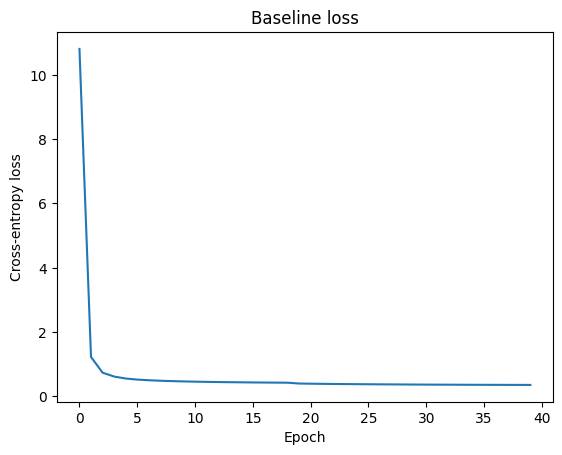

Epochs: 40
Max: 10.806319688697931, epoch: 0
Min: 0.3576966806393737, epoch: 39


In [5]:
loss_list = model_d.get("loss_list")
plt.figure()
plt.title("Baseline loss")
plt.ylabel("Cross-entropy loss")
plt.xlabel("Epoch")
plt.plot(loss_list)
plt.show()

print(f"Epochs: {len(loss_list)}")
print(f"Max: {max(loss_list)}, epoch: {np.argmax(loss_list)}")
print(f"Min: {min(loss_list)}, epoch: {np.argmin(loss_list)}")

### Average lengths

In [7]:
tgr_ls = 0
tgr_cs = 0
prd_ls = 0
prd_cs = 0
s = len(model_d.get("source_sentences"))
for tgr, prd in tqdm(zip(model_d.get("source_sentences"), model_d.get("target_sentences"))):
    # tgr = tgr.replace(";", ";\n").replace("{", "{\n").replace("}", "}\n").replace("int", "\nint").replace("float", "\nfloat")
    # prd = prd.replace(";", ";\n").replace("{", "{\n").replace("}", "}\n").replace("int", "\nint").replace("float", "\nfloat")
    
    tgr_ls += tgr.count("\n")
    prd_ls += prd.count("\n")
    
    tgr_cs += len(tgr)
    prd_cs += len(prd)
    
print("Average target lines per sample: {:.3f}".format(tgr_ls/s))
print("Average predic lines per sample: {:.3f}".format(prd_ls/s))
print("Average target sample size: {:.3f}".format(tgr_cs/s))
print("Average predic sample size: {:.3f}".format(prd_cs/s))


0it [00:00, ?it/s]

Average target lines per sample: 5.284
Average predic lines per sample: 27.398
Average target sample size: 272.834
Average predic sample size: 970.676


### Examples

In [26]:
# Generate random example from evaluation
samples = list(zip(model_d.get("source_sentences"), model_d.get("target_sentences"), model_d.get("predic_sentences")))
np.random.shuffle(samples)
for src, tgr, prd in zip(*zip(*samples)):
    
    print("SOURCE:")
    print(src)
    print("\nTARGET:")
    print(tgr)
    print("\nPREDICT:")
    # print(prd.replace(";", ";\n").replace("{", "{\n").replace("}", "}\n").replace("int", "\nint").replace("float", "\nfloat"))
    print(prd)
    print("#--------------------------#")
    break

SOURCE:
// subtract

inline __host__ __device__ int2 operator-(int2 a, int2 b)

TARGET:
// subtract

inline __host__ __device__ int2 operator-(int2 a, int2 b)
{
    return make_int2(a.x - b.x, a.y - b.y);
}

PREDICT:
______/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////